# Implied Volatility Calculation

In [1]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import random

In [2]:
# Fetch historical stock data
google_data = pd.read_excel("google_data2.xlsx")
data = google_data[google_data["Date"] >= "2021-05-06"]

# Use closing prices
close_prices = data['Last Price']

In [3]:
data

,Date,Last Price
518,2021-05-06,116.868
519,2021-05-07,117.596
520,2021-05-10,114.588
521,2021-05-11,113.503
522,2021-05-12,110.012
...,...,...
1269,2024-05-01,163.860
1270,2024-05-02,166.620
1271,2024-05-03,167.240
1272,2024-05-06,167.194


In [4]:
import numpy as np

# Calculate daily returns
returns = close_prices.pct_change().dropna()

# Parameters for EWMA
lambda_ = 0.94  # decay factor commonly used in finance

# Compute EWMA of squared returns
ewma_variance = returns.pow(2).ewm(alpha=1-lambda_).mean()
# Calculate the square root of the variance estimate
# Multiply by sqrt(252) to annualize the volatility (assuming 252 trading days per year)
implied_volatility = np.sqrt(ewma_variance * 252)


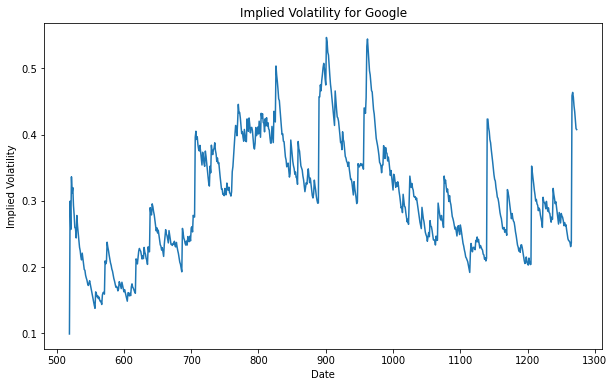

In [5]:
import matplotlib.pyplot as plt

# Plotting the implied volatility
plt.figure(figsize=(10, 6))
implied_volatility.plot(title='Implied Volatility for Google')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.show()


In [6]:
implied_volatility

519     0.098886
520     0.299547
521     0.256811
522     0.336364
523     0.312034
          ...   
1269    0.443481
1270    0.434931
1271    0.421929
1272    0.409077
1273    0.407678
Name: Last Price, Length: 755, dtype: float64

# PRICE MODELING

In [7]:
import numpy as np
import pandas as pd

# Define the dates
start_date = pd.Timestamp('2024-05-07')
end_date = pd.Timestamp('2024-08-06')

# Generate the range of dates
date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' frequency for business days

# Define holidays that might fall within the range
holidays = [pd.Timestamp('2024-05-27'),pd.Timestamp('2024-06-19'),pd.Timestamp('2024-07-04')]  # Independence Day

# Exclude holidays that fall on business days
trading_days = date_range.difference(holidays)

# Count the number of trading days
num_trading_days = len(trading_days)
num_trading_days


63

In [8]:
def gbm(W_prev):
    W_t = W_prev + np.random.normal(0, 1)
    return W_t

def price_modeling(S0, iv, N, T, r, q, day_counts):
    t = T / day_counts
    n_steps = T  # Number of time steps
    dt = t/n_steps  # Time increment
    
    prices = {}
    np.random.seed(42)  # Set seed for reproducibility
    
    for i in range(N):  # Number of simulations
        W_t = 0
        daily_prices = [S0]
        for j in range(n_steps+1):  # Simulate prices over T days
            W_t = gbm(W_t)
            S_t = S0 * np.exp((r - q - 0.5 * iv**2)*dt + iv * np.sqrt(dt) * W_t)
            daily_prices.append(S_t)
        prices[i] = daily_prices
    
    df_prices = pd.DataFrame.from_dict(prices, orient='index')
    
    return df_prices


# Asian Option Pricing

In [15]:
spot = 242
strike = 255
vol = 0.9
T = 30
N = 10000
r = 0.05
q = 0
day_counts = 252

In [16]:
def euro_option_price(spot, implied_vol, N, T, r, q, day_counts):
    sim_prices = price_modeling(spot, implied_vol, N, T, r, q, day_counts)
    european_payoff = np.maximum(sim_prices[T] - strike, 0) * np.exp(-r*T/day_counts)
    european_price = european_payoff.mean()
    return european_price

In [59]:
def asian_option_price(spot, implied_vol, N, T, r, q, day_counts):
    sim_prices = price_modeling(spot, implied_vol, N, T, r, q, day_counts)
    avgs = sim_prices.mean(axis=1)
    payoffs = (avgs - strike).clip(lower=0)
    expected_payoff = payoffs.mean(axis=0)
    option_price = expected_payoff * np.exp(-(r*T/day_counts))
    return option_price

In [60]:
asian_call = asian_option_price(spot, vol, N, T, r, q, day_counts)
print("Price:", asian_call)

Price: 6.755750900989563


# Control Variate

In [61]:
from scipy.stats import norm
t = T / day_counts
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

expected_european = black_scholes_call(spot, strike, t, r, vol)
expected_european

11.967419525404424

In [62]:
def asian_option_price_control_variate(spot, implied_vol, N, T, r, q, day_counts):
    sim_prices = price_modeling(spot, implied_vol, N, T, r, q, day_counts)
    avgs = sim_prices.mean(axis=1)
    asian_payoff = (avgs - strike).clip(lower=0) * np.exp(-(r*T/day_counts))
    asian_price = asian_payoff.mean(axis=0)
    
    
    european_payoff = np.maximum(sim_prices[T] - strike, 0) * np.exp(-r*T/day_counts)
    european_price = european_payoff.mean()
    
    expected_european = black_scholes_call(spot, strike, t, r, vol)
    
    cov = np.cov(asian_payoff, european_payoff)[0, 1]
    var = np.var(european_payoff)
    c = -cov / var  # control variate coefficient

    aop = asian_payoff.mean() + c * (european_payoff.mean() - expected_european)

    return asian_price, aop

In [63]:
asian_call = asian_option_price_control_variate(spot, vol, N, T, r, q, day_counts)
print("Price:", asian_call[0], asian_call[1])

Price: 6.755750900989551 6.77523907659822


In [ ]:
df = price_modeling(spot, vol, N, T, r, q, day_counts)

plt.figure(figsize=(10, 6))  # Set the figure size
for index, row in df.iterrows():
    plt.plot(row, label=f'Simulation {index + 1}')

plt.title('Stock Price Simulations Over Time')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.show()
